#LSTM Music Generation using Midi files on Beethovan's Music

##Importing Libraries

In [ ]:
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import os
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping, History
%matplotlib inline
import IPython
from IPython.display import Image, Audio
from tensorflow.keras.utils import plot_model
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Generating Chords and Notes

In [ ]:
from music21 import *

def notes_chods(file_path):
    notes = []
    midi = converter.parse(file_path)

    parse_element = lambda element: notes.append(str(element.pitch)) if type(element) == note.Note \
    else notes.append('.'.join(str(n) for n in element.normalOrder)) if type(element) == chord.Chord else None

    parts = instrument.partitionByInstrument(midi)
    for part in parts:
        # iterate over the notes and chords
        for element in part.recurse():
                parse_element(element)

    return notes

##Extracting Chrods and Notes for all MIDI files of Beethoven

In [ ]:
# extracting chrods ans notes for all files of beethoven!!
dir = '/content/drive/MyDrive/ML_Project/data/beeth'
chords_corpus = []
for filename in os.listdir(dir):
    if filename.endswith('.mid'):
        filepath = os.path.join(dir, filename)
        chords_corpus.append(notes_chods(filepath))

In [ ]:
# here the lenth is equal to the total files
print("The toatl number of files: ",(len(chords_corpus)))
all_chords = sum(chords_corpus, [])
print("The toatl number of chords in the whole corpus: ",len(all_chords))

The toatl number of files:  29
The toatl number of chords in the whole corpus:  81312


# EDA

In [ ]:
# all the  unique chords in the files
unique_chords = set(all_chords)
("The number of unique chords in whole corpus: ", len(unique_chords))

('The number of unique chords in whole corpus: ', 349)

In [ ]:
# Counts of each chords in the corpus
code_counts = Counter(all_chords)

### Frequencies Of the Chords

In [ ]:
print("Average recurrenc for a note in the whole dataset:", str(sum(code_counts.values())/len(code_counts)))
print("Most frequent note in whole dataset:", str(max(code_counts.items(), key=lambda x: x[1])), "times")
print("Least frequent note in whole dataset:", str(min(code_counts.items(), key=lambda x: x[1])), "time")

Average recurrenc for a note in the whole dataset: 232.98567335243553
Most frequent note in whole dataset: ('C4', 2094) times
Least frequent note in whole dataset: ('11.3.5', 1) time


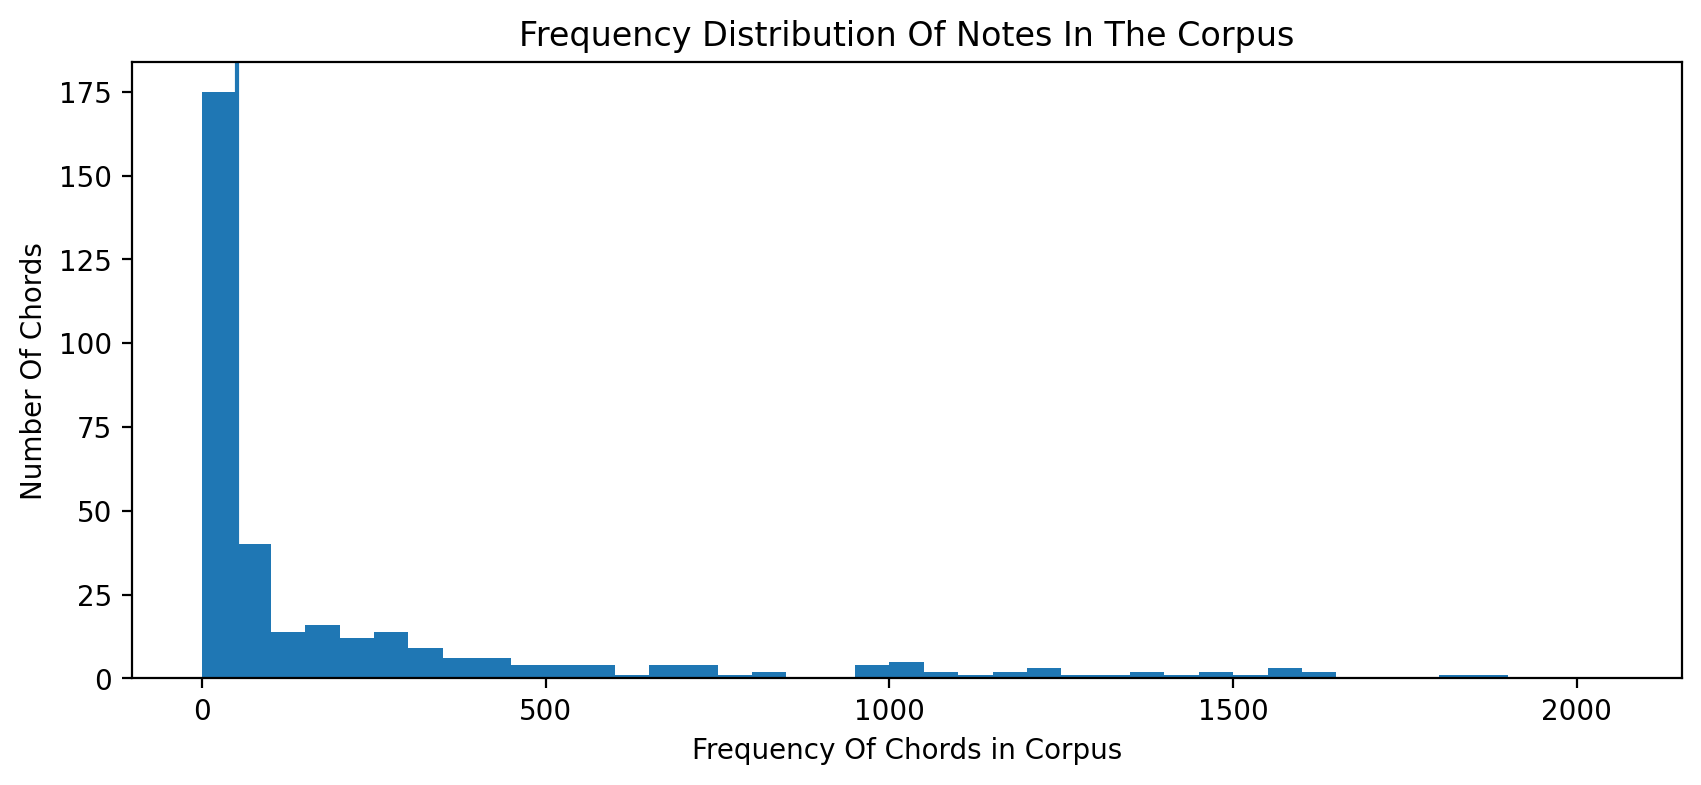

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(10,4))
plt.hist(code_counts.values(), bins=np.arange(0,(max(code_counts.values())), 50))
plt.axvline(x=50)

plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

###Top 20 Chords played

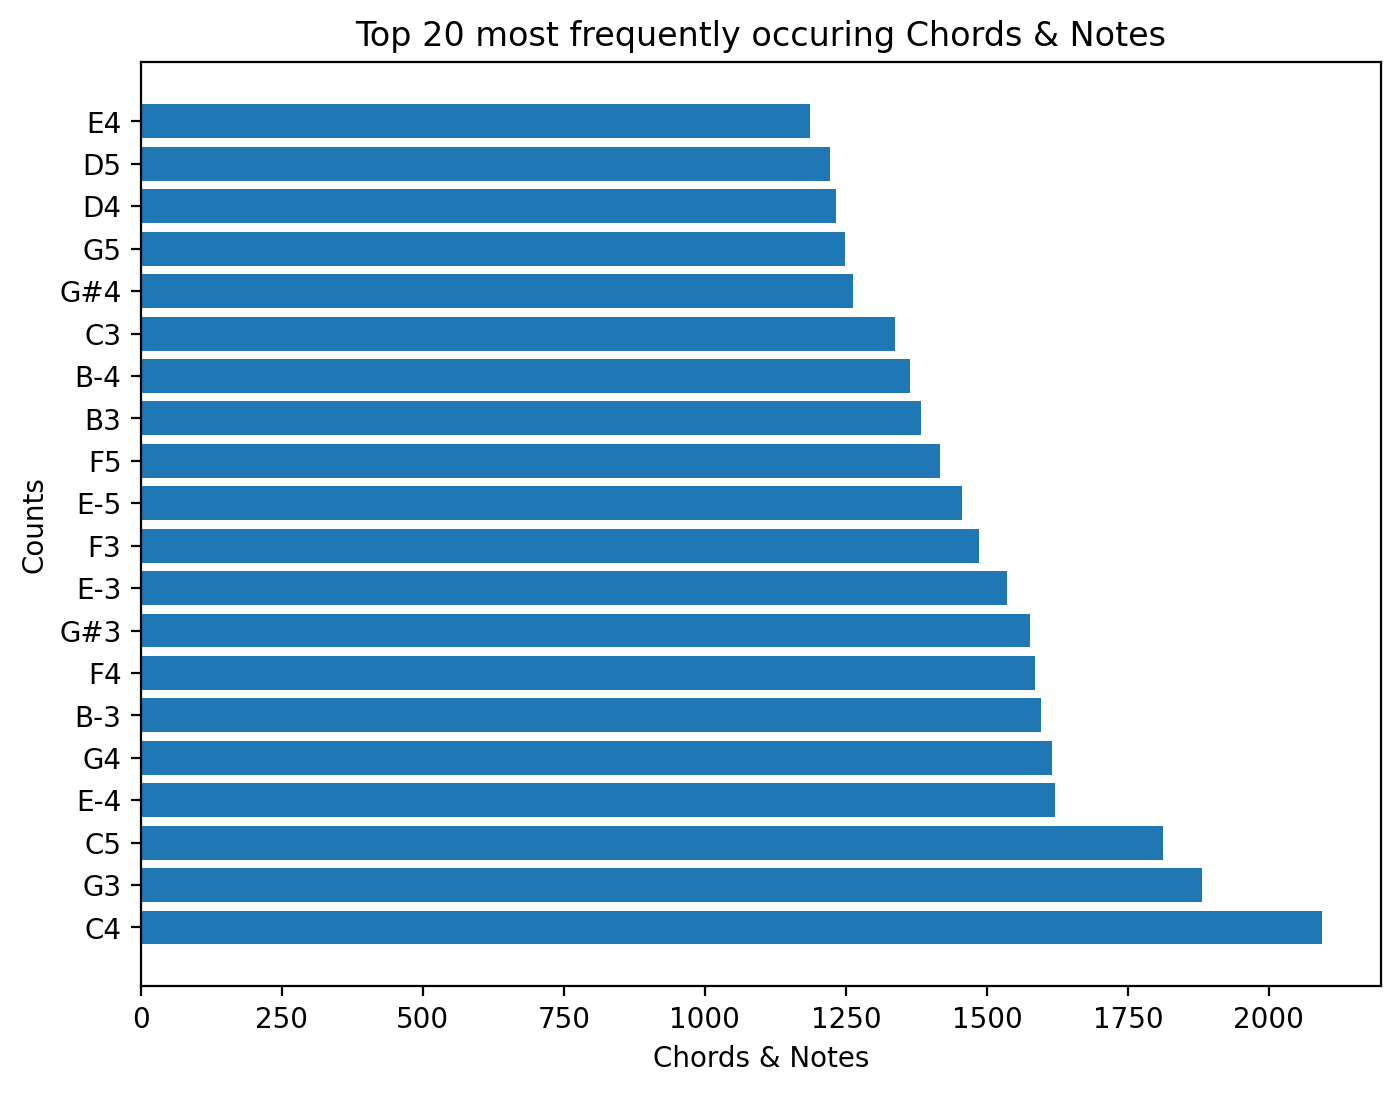

In [ ]:
sorted_data = sorted(code_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract the keys and values into separate lists
labels = [x[0] for x in sorted_data]
values = [x[1] for x in sorted_data]

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(labels, values)

# Set the title and axis labels
ax.set_title('Top 20 most frequently occuring Chords & Notes')
ax.set_xlabel('Chords & Notes')
ax.set_ylabel('Counts')

# Show the plot
plt.show()

### Total number rare chords

In [ ]:
rare_chords_lst = [key for key, value in code_counts.items() if value < 50]
print("Total rare codes:",len(rare_chords_lst))

Total rare codes: 175


### Total number frequent Chords after removing rare chords

In [ ]:
frequent_chords_lst = [code for code in all_chords if code not in rare_chords_lst]
print("Total frequent codes:",len(frequent_chords_lst))

Total frequent codes: 79744


###Building dictionary to access the vocabulary from indices and vice versa

In [ ]:
chords_orderd = dict((c, i) for i, c in enumerate(sorted(set(frequent_chords_lst))))
reverse_chords_orderd= dict((i, c) for i, c in enumerate(sorted(set(frequent_chords_lst))))

print("Total number of characters:", len(all_chords))
print("Number of unique characters:", len(set(frequent_chords_lst)))

Total number of characters: 81312
Number of unique characters: 174


# Creating the data corpus

In [ ]:
length = 70
features = []
targets = []
for i in range(0, len(frequent_chords_lst) - length, 1):
    feature = frequent_chords_lst[i: i+length]
    target = frequent_chords_lst[i + length]
    features.append([chords_orderd[j] for j in feature])
    targets.append(chords_orderd[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 79674


### Normalizing the data

In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(len(sorted(list(set(frequent_chords_lst)))))
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
X.shape

(79674, 70, 1)

###Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Initialising the Model
* By defining Layers
* Compiling the Model
* Training the Model
* couple of the code were understood and implemented from various sources [link](https://blog.paperspace.com/music-generation-with-lstms/) , [link](https://www.kaggle.com/code/karnikakapoor/music-generation-lstm)

#### Model with ADAMAX Optimizer

In [ ]:
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adamax

# Initializing the Model
model = Sequential()

# Defining the regularization strength
reg_strength = 0.01

# Adding layers
layers = [LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
          Dropout(0.1),
          LSTM(128),
          Dense(128),
          Dropout(0.1),
          Dense(y.shape[1], activation='softmax')]

# Adding regularization to each layer
for i in range(len(layers)):
    if isinstance(layers[i], (LSTM, Dense)):
        layers[i].kernel_regularization = l2(reg_strength)
        layers[i].recurrent_regularization = l2(reg_strength)

# Adding layers to the model
for layer in layers:
    model.add(layer)

# Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70, 512)           1052672   
                                                                 
 dropout_4 (Dropout)         (None, 70, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 174)               44718     
                                                                 
Total params: 1,950,638
Trainable params: 1,950,638
No

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 4, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=100, callbacks = [early_stop, History()])

Epoch 1/100
249/249 [==============================] - 19s 78ms/step - loss: 4.4813
Epoch 2/100
249/249 [==============================] - 20s 79ms/step - loss: 4.4808
Epoch 3/100
249/249 [==============================] - 19s 76ms/step - loss: 4.4628
Epoch 4/100
249/249 [==============================] - 19s 75ms/step - loss: 4.4450
Epoch 5/100
249/249 [==============================] - 19s 76ms/step - loss: 4.4133
Epoch 6/100
249/249 [==============================] - 19s 76ms/step - loss: 4.3701
Epoch 7/100
249/249 [==============================] - 19s 75ms/step - loss: 4.3301
Epoch 8/100
249/249 [==============================] - 19s 76ms/step - loss: 4.2765
Epoch 9/100
249/249 [==============================] - 19s 75ms/step - loss: 4.2100
Epoch 10/100
249/249 [==============================] - 19s 76ms/step - loss: 4.1328
Epoch 11/100
249/249 [==============================] - 19s 76ms/step - loss: 4.0175
Epoch 12/100
249/249 [==============================] - 19s 76ms/step - lo

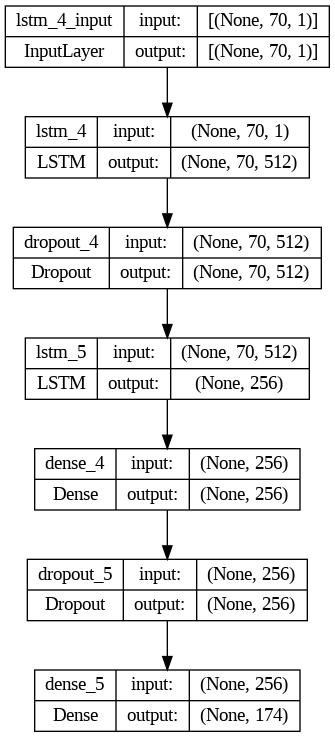

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/ML_Project/model_Adamax.png', show_shapes=True, show_layer_names=True)

#### Model with Rsmprop Optimizer

In [ ]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Initializing the Model
model_1 = Sequential()

# Defining the regularization strength
reg_strength = 0.01

# Adding layers
layers = [LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
          Dropout(0.1),
          LSTM(128),
          Dense(128),
          Dropout(0.1),
          Dense(y.shape[1], activation='softmax')]

# Adding regularization to each layer
for i in range(len(layers)):
    if isinstance(layers[i], (LSTM, Dense)):
        layers[i].kernel_regularization = l2(reg_strength)
        layers[i].recurrent_regularization = l2(reg_strength)

# Adding layers to the model
for layer in layers:
    model_1.add(layer)

# Compiling the model for training
opt = RMSprop(lr=0.001, rho=0.9)
model_1.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
history_2 = model_1.fit(X_train, y_train, batch_size=256, epochs=100, callbacks = [early_stop, History()])

Epoch 1/100
249/249 [==============================] - 10s 27ms/step - loss: 4.6434
Epoch 2/100
249/249 [==============================] - 7s 27ms/step - loss: 4.5567
Epoch 3/100
249/249 [==============================] - 7s 27ms/step - loss: 4.5356
Epoch 4/100
249/249 [==============================] - 7s 28ms/step - loss: 4.5128
Epoch 5/100
249/249 [==============================] - 7s 27ms/step - loss: 4.4723
Epoch 6/100
249/249 [==============================] - 7s 27ms/step - loss: 4.4323
Epoch 7/100
249/249 [==============================] - 7s 27ms/step - loss: 4.3925
Epoch 8/100
249/249 [==============================] - 7s 27ms/step - loss: 4.3517
Epoch 9/100
249/249 [==============================] - 7s 27ms/step - loss: 4.3093
Epoch 10/100
249/249 [==============================] - 7s 27ms/step - loss: 4.2617
Epoch 11/100
249/249 [==============================] - 7s 27ms/step - loss: 4.2135
Epoch 12/100
249/249 [==============================] - 7s 27ms/step - loss: 4.1580


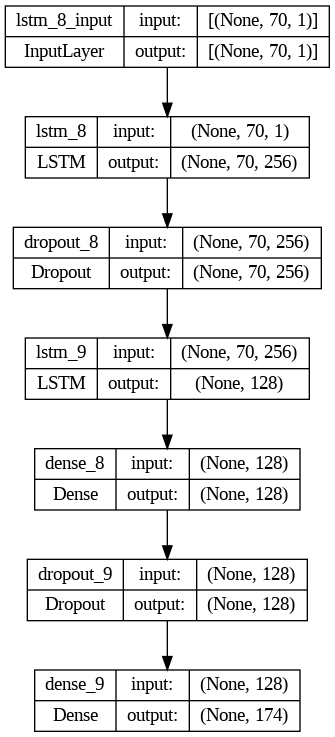

In [ ]:
plot_model(model_1, to_file='/content/drive/MyDrive/ML_Project/model_RMSprop.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.layers

## Defining the Music Generation function

In [ ]:
from music21 import *
import numpy as np

def generate_melody(Note_Count, X_test, selected_model, frequent_chords_lst, reverse_chords_orderd):

    # Function to convert chord strings to notes and chords
    def chords_n_notes(Snippet):
        Melody = []
        offset = 0 #Incremental
        for i in Snippet:
            #If it is chord
            if ("." in i or i.isdigit()):
                chord_notes = i.split(".") #Seperating the notes in chord
                notes = []
                for j in chord_notes:
                    inst_note=int(j)
                    note_snip = note.Note(inst_note)
                    notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
            # pattern is a note
            else:
                note_snip = note.Note(i)
                note_snip.offset = offset
                Melody.append(note_snip)
            # increase offset each iteration so that notes do not stack
            offset += 1
        Melody_midi = stream.Stream(Melody)
        return Melody_midi

    length = 70
    seed = X_test[np.random.randint(0,len(X_test)-1)]
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = selected_model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(len(sorted(list(set(frequent_chords_lst)))))
        Notes_Generated.append(index)
        Music = [reverse_chords_orderd[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

### Generating Music with ADAMAX Model

In [ ]:
Melodymidi = generate_melody(70, X_test, model, frequent_chords_lst, reverse_chords_orderd)
Melodymidi.write('midi','/content/drive/MyDrive/ML_Project/test_output/Melody_Adamax.mid')

'/content/drive/MyDrive/ML_Project/test_output/Melody_Adamax.mid'

Generating Music with RMSPROP Model

In [ ]:
Melodymidi_1 = generate_melody(70, X_test, model_1, frequent_chords_lst, reverse_chords_orderd)
Melodymidi_1.write('midi','/content/drive/MyDrive/ML_Project/test_output/Melody_RMSprop.mid')

'/content/drive/MyDrive/ML_Project/test_output/Melody_RMSprop.mid'

##  Saving the Weighs of two models

In [ ]:
model.save('/content/drive/MyDrive/ML_Project/test_output/model_Adamax.h5') #
model_1.save('/content/drive/MyDrive/ML_Project/test_output/model_RMSprop.h5') #

# Conclusion

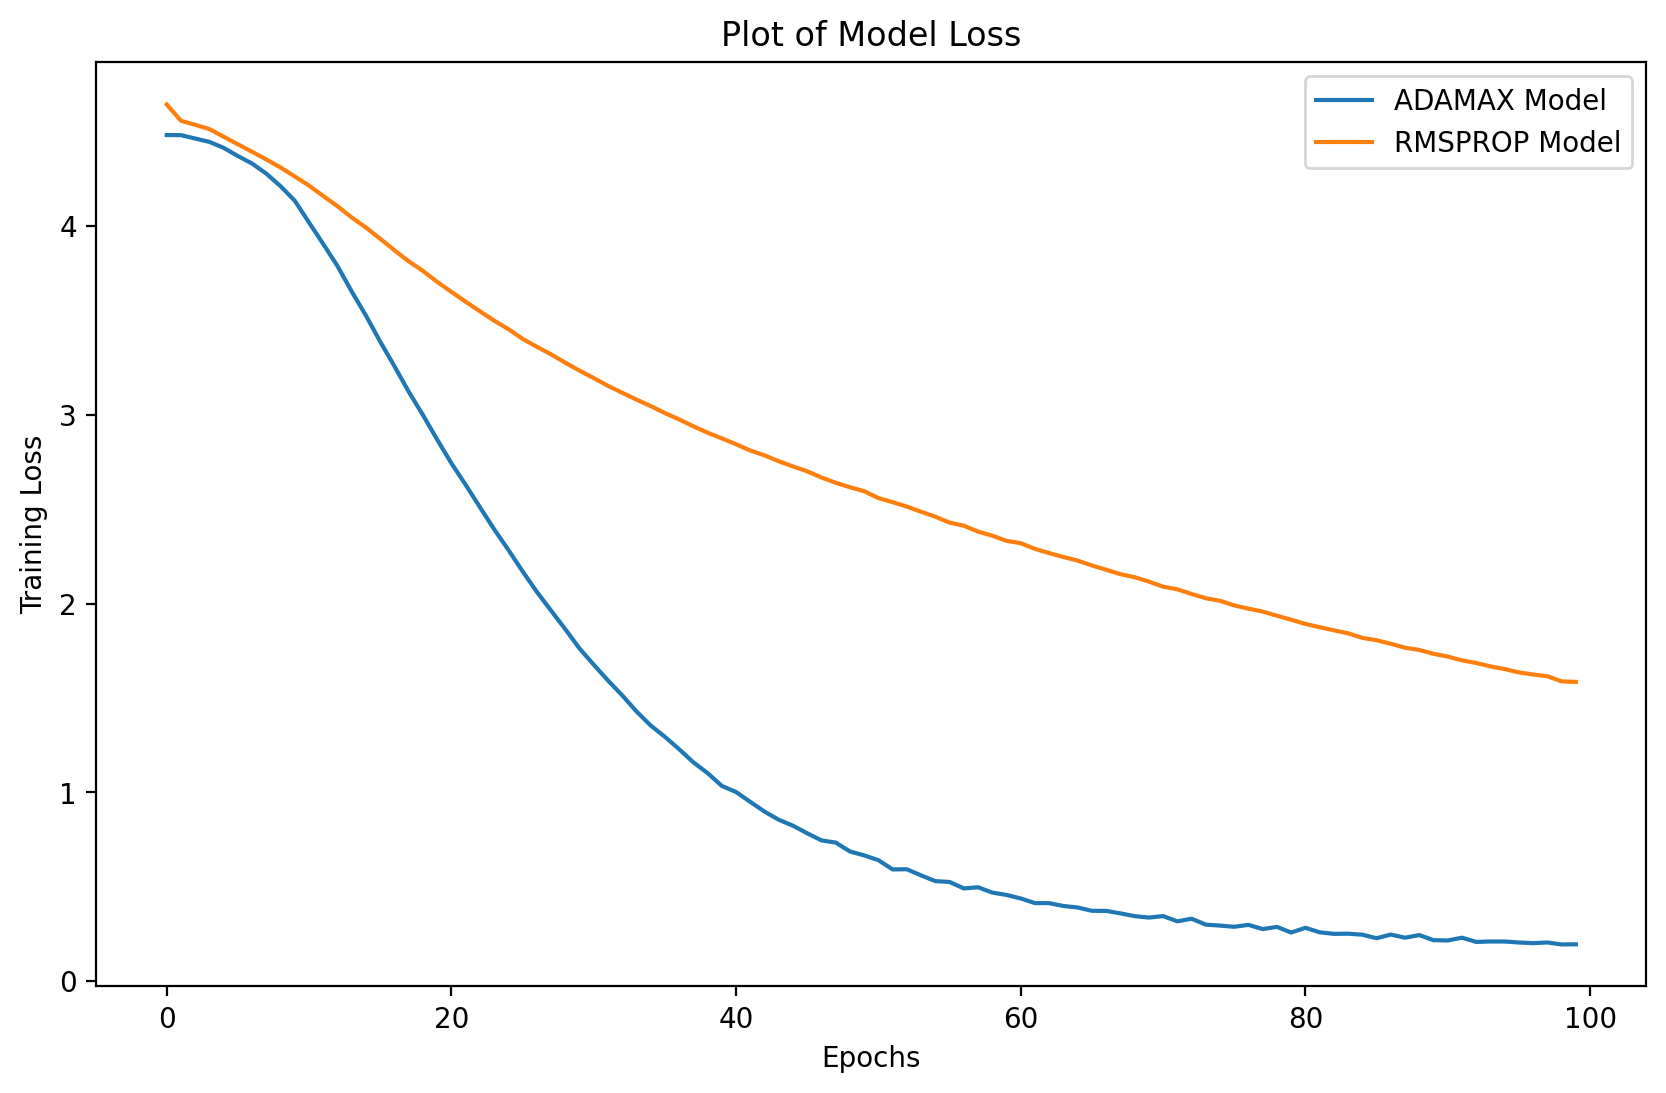

In [ ]:
history_df = pd.DataFrame(history.history)
history_df_2 = pd.DataFrame(history_2.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df["loss"])
plt.plot(history_df_2["loss"])
plt.title("Plot of Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend(["ADAMAX Model", "RMSPROP Model"])
plt.show()